<a href="https://colab.research.google.com/github/ParthPatel101/iSPY/blob/main/iSPY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This program uses LSTM (Long Short Term Memory) to predict the stock price of the SPY 500 index using past data.

In [2]:
import math
import pandas_datareader as web
import yfinance as yf
import datetime as dt
from dateutil.relativedelta import relativedelta
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

In [3]:
# Full dataset from the start of SPY to today
start = dt.datetime(1993, 1, 29)
end = dt.datetime.today()
df = yf.download('SPY', start, end)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-01-29,43.968750,43.968750,43.750000,43.937500,25.438095,1003200
1993-02-01,43.968750,44.250000,43.968750,44.250000,25.619007,480500
1993-02-02,44.218750,44.375000,44.125000,44.343750,25.673290,201300
1993-02-03,44.406250,44.843750,44.375000,44.812500,25.944704,529400
1993-02-04,44.968750,45.093750,44.468750,45.000000,26.053244,531500
...,...,...,...,...,...,...
2022-07-18,388.380005,389.089996,380.660004,381.950012,381.950012,63203600
2022-07-19,386.079987,392.869995,385.390015,392.269989,392.269989,78506000
2022-07-20,392.470001,396.260010,391.029999,394.769989,394.769989,71843800


In [4]:
# More recent dataset (past 20 years)
recent_start = dt.datetime.today() - relativedelta(years = 20)
recent_df = yf.download('SPY', recent_start, end)
recent_df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-07-25,84.269997,85.849998,81.599998,84.000000,57.191036,87176600
2002-07-26,84.650002,85.930000,83.800003,85.599998,58.280418,41206800
2002-07-29,87.500000,90.339996,87.300003,89.769997,61.119530,53492900
2002-07-30,89.320000,91.400002,88.720001,90.940002,61.916142,47532200
2002-07-31,90.489998,91.550003,89.250000,91.160004,62.065918,44669900
...,...,...,...,...,...,...
2022-07-18,388.380005,389.089996,380.660004,381.950012,381.950012,63203600
2022-07-19,386.079987,392.869995,385.390015,392.269989,392.269989,78506000
2022-07-20,392.470001,396.260010,391.029999,394.769989,394.769989,71843800


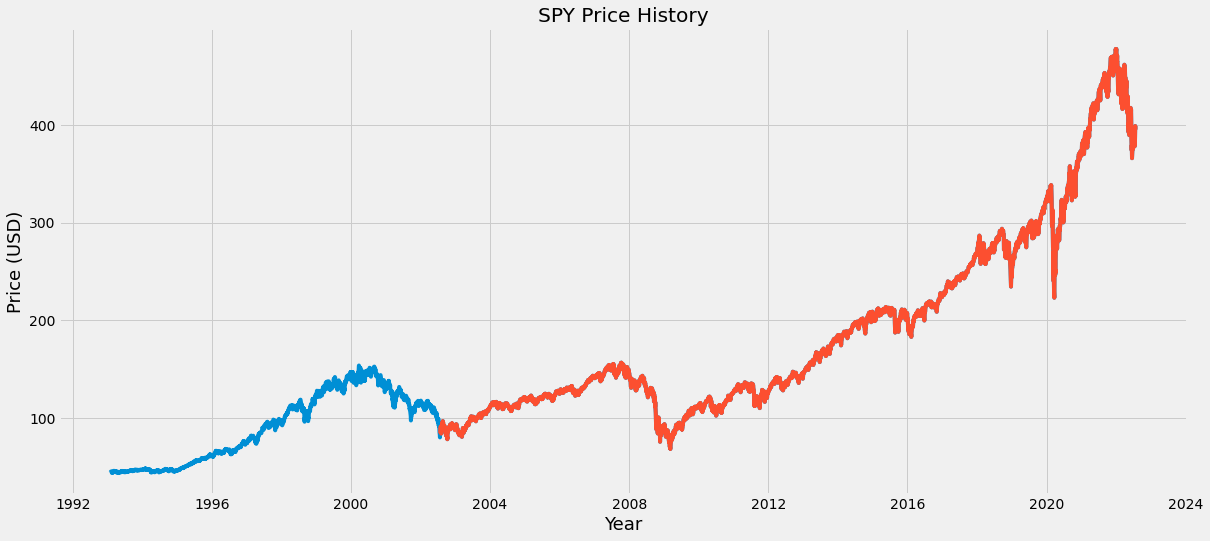

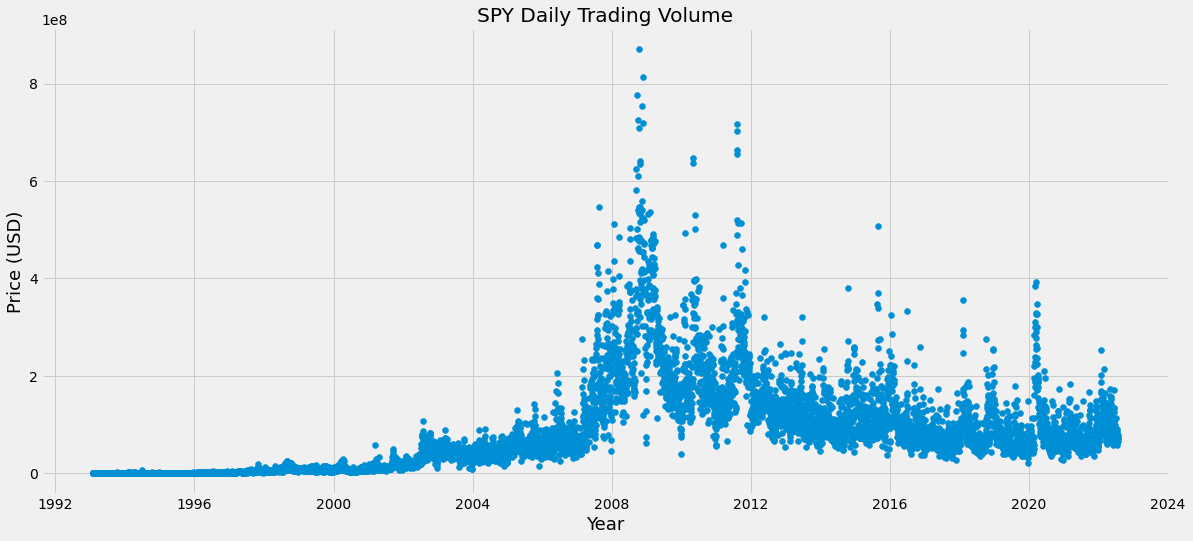

In [5]:
plt.figure(figsize=(18,8))
plt.title("SPY Price History")
plt.plot(df["Close"])
plt.plot(recent_df["Close"]) # Plots the recent subset of the total dataset in a different color
plt.xlabel("Year", fontsize = 18)
plt.ylabel("Price (USD)", fontsize = 18)
plt.show()

plt.figure(figsize=(18,8))
plt.title("SPY Daily Trading Volume")
plt.scatter(df.index, df["Volume"])
plt.xlabel("Year", fontsize = 18)
plt.ylabel("Price (USD)", fontsize = 18)
plt.show()


In [6]:
# Add 50 day moving average, daily percent change, and rate of return
df["MA50"] = df["Close"].rolling(50).mean().fillna(0)
df["1D"] = df["Close"].pct_change().fillna(0)
df["ROR"] = (((df["Close"] - df["Close"][0]) / df["Close"][0]) * 100).round(2)
df

,Open,High,Low,Close,Adj Close,Volume,MA50,1D,ROR
Date,,,,,,,,,
1993-01-29,43.968750,43.968750,43.750000,43.937500,25.438095,1003200,0.000000,0.000000,0.00
1993-02-01,43.968750,44.250000,43.968750,44.250000,25.619007,480500,0.000000,0.007112,0.71
1993-02-02,44.218750,44.375000,44.125000,44.343750,25.673290,201300,0.000000,0.002119,0.92
1993-02-03,44.406250,44.843750,44.375000,44.812500,25.944704,529400,0.000000,0.010571,1.99
1993-02-04,44.968750,45.093750,44.468750,45.000000,26.053244,531500,0.000000,0.004184,2.42
...,...,...,...,...,...,...,...,...,...
2022-07-18,388.380005,389.089996,380.660004,381.950012,381.950012,63203600,391.915400,-0.008257,769.30
2022-07-19,386.079987,392.869995,385.390015,392.269989,392.269989,78506000,391.484600,0.027019,792.79
2022-07-20,392.470001,396.260010,391.029999,394.769989,394.769989,71843800,391.153199,0.006373,798.48


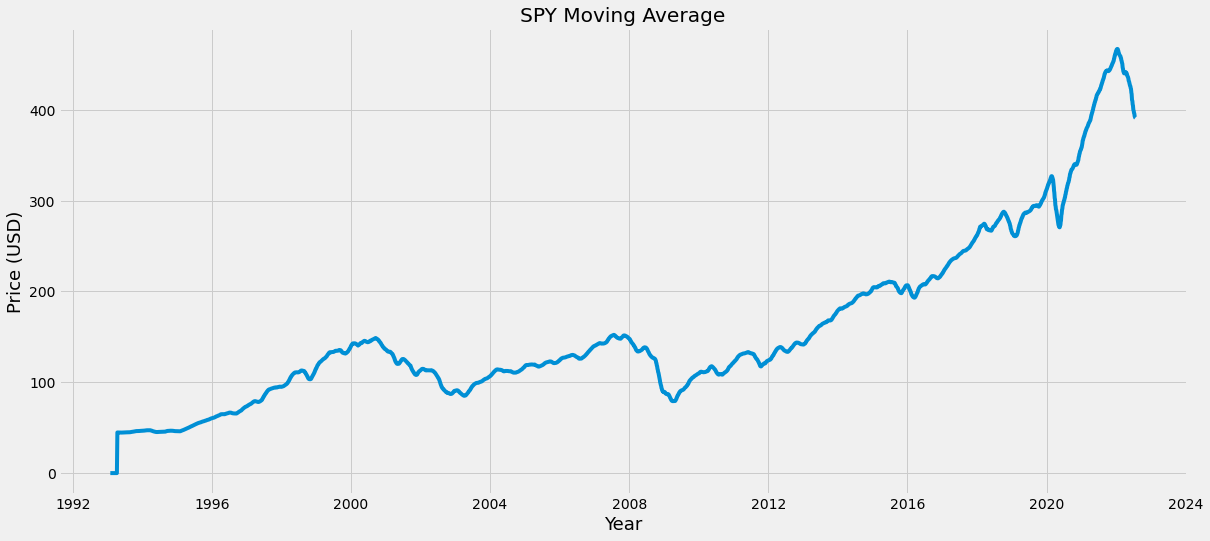

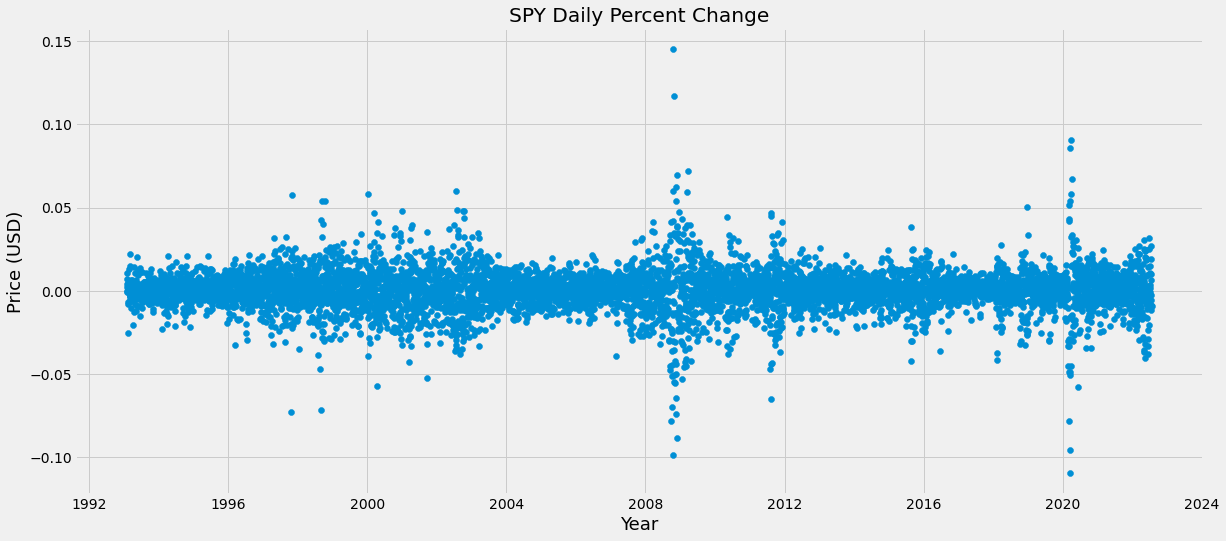

In [7]:
plt.figure(figsize=(18,8))
plt.title("SPY Moving Average")
plt.plot(df["MA50"])
plt.xlabel("Year", fontsize = 18)
plt.ylabel("Price (USD)", fontsize = 18)
plt.show()

plt.figure(figsize=(18,8))
plt.title("SPY Daily Percent Change")
plt.scatter(df["1D"].index , df["1D"])
plt.xlabel("Year", fontsize = 18)
plt.ylabel("Price (USD)", fontsize = 18)
plt.show()

In [8]:
# Gets data from two stocks that largely compose the SPY index
start = dt.datetime(1993, 1, 29)
end = dt.datetime.today()
AMZN = yf.download("AMZN", start, end)
MSFT = yf.download("MSFT", start, end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [9]:
data = df.filter(["Close"])
dataset = data.values
training_data_length = math.ceil(len(dataset) * 0.95) # Training data percentage is high because predictions are largely based on very recent activity
print(training_data_length)

recent_data = recent_df.filter(["Close"])
recent_dataset = recent_data.values
recent_training_data_length = math.ceil(len(recent_dataset) * 0.95) # Training data percentage is high because predictions are largely based on very recent activity
print(recent_training_data_length)


7053
4783


In [10]:
scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(dataset)
print(scaled_data)

print()

recent_scaled_data = scaler.fit_transform(recent_dataset)
print(recent_scaled_data)

[[0.00122322]
 [0.00194276]
 [0.00215863]
 ...
 [0.80902766]
 [0.8182839 ]
 [0.80976449]]

[[0.03879394]
 [0.04270019]
 [0.05288085]
 ...
 [0.79750976]
 [0.80732426]
 [0.79829102]]


In [11]:
train_data = scaled_data[0:training_data_length]
x_train = []
y_train = []
for i in range(60, training_data_length):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])
  if i <= 60:
    print(x_train)
    print(y_train)
    print()

recent_train_data = recent_scaled_data[0:recent_training_data_length]
recent_x_train = []
recent_y_train = []
for i in range(60, recent_training_data_length):
  recent_x_train.append(recent_train_data[i-60:i, 0])
  recent_y_train.append(recent_train_data[i, 0])
  if i <= 60:
    print(recent_x_train)
    print(recent_y_train)
    print()

[array([1.22322225e-03, 1.94276475e-03, 2.15862750e-03, 3.23794125e-03,
       3.66966675e-03, 3.59771250e-03, 3.59771250e-03, 2.87817000e-03,
       3.02207850e-03, 3.52575825e-03, 2.73426150e-03, 1.43908500e-04,
       7.19542500e-05, 0.00000000e+00, 3.59771250e-04, 7.19542500e-04,
       6.47588250e-04, 1.94276475e-03, 2.15862750e-03, 2.30253600e-03,
       2.01471900e-03, 3.52575825e-03, 3.95748375e-03, 3.38184975e-03,
       3.09403275e-03, 5.39656875e-03, 5.03679750e-03, 5.25266025e-03,
       4.96484325e-03, 3.88552950e-03, 4.38920925e-03, 4.38920925e-03,
       3.74162100e-03, 4.38920925e-03, 3.74162100e-03, 3.16598700e-03,
       3.38184975e-03, 3.38184975e-03, 4.02943800e-03, 3.45380400e-03,
       3.88552950e-03, 4.17334650e-03, 4.10139225e-03, 3.74162100e-03,
       1.58299350e-03, 2.08667325e-03, 1.79885625e-03, 2.15862750e-03,
       2.01471900e-03, 3.45380400e-03, 3.66966675e-03, 3.52575825e-03,
       3.52575825e-03, 3.52575825e-03, 3.09403275e-03, 2.59035300e-03,
     

In [12]:
x_train, y_train = np.array(x_train), np.array(y_train)

recent_x_train, recent_y_train = np.array(recent_x_train), np.array(recent_y_train)

In [13]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape)

recent_x_train = np.reshape(recent_x_train, (recent_x_train.shape[0], recent_x_train.shape[1], 1))
print(recent_x_train.shape)

(6993, 60, 1)
(4723, 60, 1)


In [14]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (x_train.shape[1],1)))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))

recent_model = Sequential()
recent_model.add(LSTM(50, return_sequences = True, input_shape = (recent_x_train.shape[1],1)))
recent_model.add(LSTM(50, return_sequences = False))
recent_model.add(Dense(25))
recent_model.add(Dense(1))

In [15]:
model.compile(optimizer = "adam", loss = "mean_squared_error")

recent_model.compile(optimizer = "adam", loss = "mean_squared_error")

In [16]:
model.fit(x_train, y_train, batch_size = 1, epochs = 1)

recent_model.fit(recent_x_train, recent_y_train, batch_size = 1, epochs = 1)

4723/4723 [==============================] - 144s 30ms/step - loss: 4.7574e-04


In [17]:
test_data = scaled_data[training_data_length - 60:]
x_test = []
y_test = dataset[training_data_length:]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i,0])

recent_test_data = recent_scaled_data[recent_training_data_length - 60:]
recent_x_test = []
recent_y_test = recent_dataset[recent_training_data_length:]
for i in range(60, len(recent_test_data)):
  recent_x_test.append(recent_test_data[i-60:i,0])

In [18]:
x_test = np.array(x_test)

recent_x_test = np.array(recent_x_test)

In [19]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

recent_x_test = np.reshape(recent_x_test, (recent_x_test.shape[0], recent_x_test.shape[1], 1))


In [20]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

recent_predictions = recent_model.predict(recent_x_test)
recent_predictions = scaler.inverse_transform(recent_predictions)


In [21]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
print(rmse)

recent_rmse = np.sqrt(np.mean(recent_predictions - recent_y_test)**2)
print(recent_rmse)

3.403399444333305
12.543542991121452


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


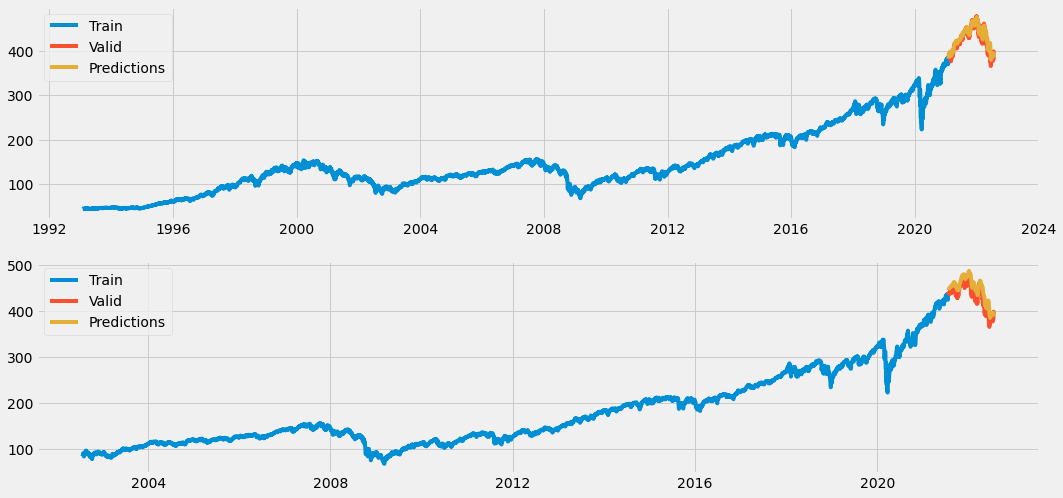

In [22]:
train = data[:training_data_length]
valid = data[training_data_length:]
valid.loc[:, "Predictions"] = predictions
valid.loc[:, "Error"] = abs(valid["Close"] - valid["Predictions"])

recent_train = recent_data[:recent_training_data_length]
recent_valid = recent_data[recent_training_data_length:]
recent_valid.loc[:, "Predictions"] = recent_predictions
recent_valid.loc[:, "Error"] = abs(recent_valid["Close"] - recent_valid["Predictions"])

plt.figure(figsize = (16,8))
plt.title("SPY Price History")
plt.xlabel("Year", fontsize = 18)
plt.ylabel("Price (USD)", fontsize = 18)

plt.subplot(211)
plt.plot(train["Close"])
plt.plot(valid[["Close", "Predictions"]])
plt.legend(["Train", "Valid", "Predictions"], loc = "best")

plt.subplot(212)
plt.plot(recent_train["Close"])
plt.plot(recent_valid[["Close", "Predictions"]])
plt.legend(["Train", "Valid", "Predictions"], loc = "best")
plt.show()

In [23]:
valid

,Close,Predictions,Error
Date,,,
2021-02-02,381.549988,382.616211,1.066223
2021-02-03,381.850006,384.027008,2.177002
2021-02-04,386.190002,385.834320,0.355682
2021-02-05,387.709991,388.433533,0.723541
2021-02-08,390.510010,390.922729,0.412720
...,...,...,...
2022-07-18,381.950012,388.298126,6.348114
2022-07-19,392.269989,388.645416,3.624573
2022-07-20,394.769989,391.580475,3.189514


In [24]:
recent_valid

,Close,Predictions,Error
Date,,,
2021-07-26,441.019989,445.890320,4.870331
2021-07-27,439.010010,447.590820,8.580811
2021-07-28,438.829987,448.743439,9.913452
2021-07-29,440.649994,449.501251,8.851257
2021-07-30,438.510010,450.299591,11.789581
...,...,...,...
2022-07-18,381.950012,392.589294,10.639282
2022-07-19,392.269989,392.558380,0.288391
2022-07-20,394.769989,394.307587,0.462402


In [25]:
# Calcualte model accuracy for both datasets
from sklearn.metrics import r2_score

accuracy = r2_score(valid["Close"], valid["Predictions"])
print("Model accuracy for large/complete dataset: {}%".format(round(accuracy * 100, 2)))

recent_accuracy = r2_score(recent_valid["Close"], recent_valid["Predictions"])
print("Model accuracy for recent dataset: {}%".format(round(recent_accuracy * 100, 2)))

Model accuracy for large/complete dataset: 92.8%
Model accuracy for recent dataset: 69.4%


In [26]:
new_df = df.filter(["Close"])
last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)
new_x_test = []
new_x_test.append(last_60_days_scaled)
new_x_test = np.array(new_x_test)
new_x_test = np.reshape(new_x_test, (new_x_test.shape[0], new_x_test.shape[1], 1))
pred_price = model.predict(new_x_test, )
pred_price = scaler.inverse_transform(pred_price)
print("Predicted close price for SPY for next trading day using full dataset: ${:0.2f}".format(round(pred_price[0][0], 2)))

recent_new_df = recent_df.filter(["Close"])
recent_last_60_days = recent_new_df[-60:].values
recent_last_60_days_scaled = scaler.transform(recent_last_60_days)
recent_new_x_test = []
recent_new_x_test.append(recent_last_60_days_scaled)
recent_new_x_test = np.array(recent_new_x_test)
recent_new_x_test = np.reshape(recent_new_x_test, (recent_new_x_test.shape[0], recent_new_x_test.shape[1], 1))
recent_pred_price = recent_model.predict(recent_new_x_test, )
recent_pred_price = scaler.inverse_transform(recent_pred_price)

print("Predicted close price for next trading day SPY using a more recent dataset: ${:0.2f}".format(round(recent_pred_price[0][0], 2)))

Predicted close price for SPY for next trading day using full dataset: $395.90
Predicted close price for next trading day SPY using a more recent dataset: $401.86


In [27]:
new_df = df.filter(["Close"])
recent_new_df = recent_df.filter(["Close"])

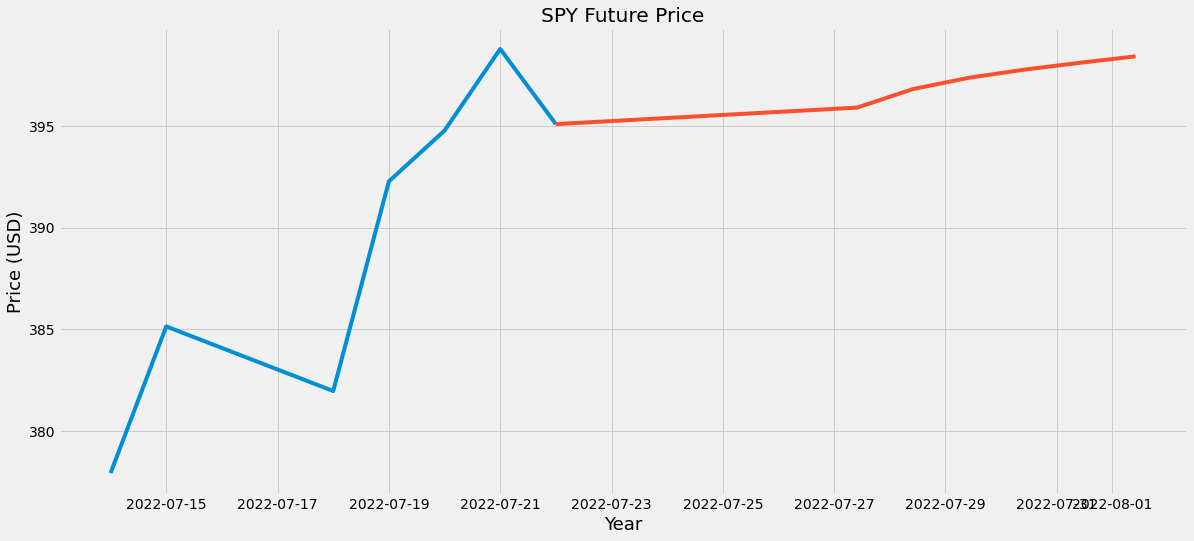

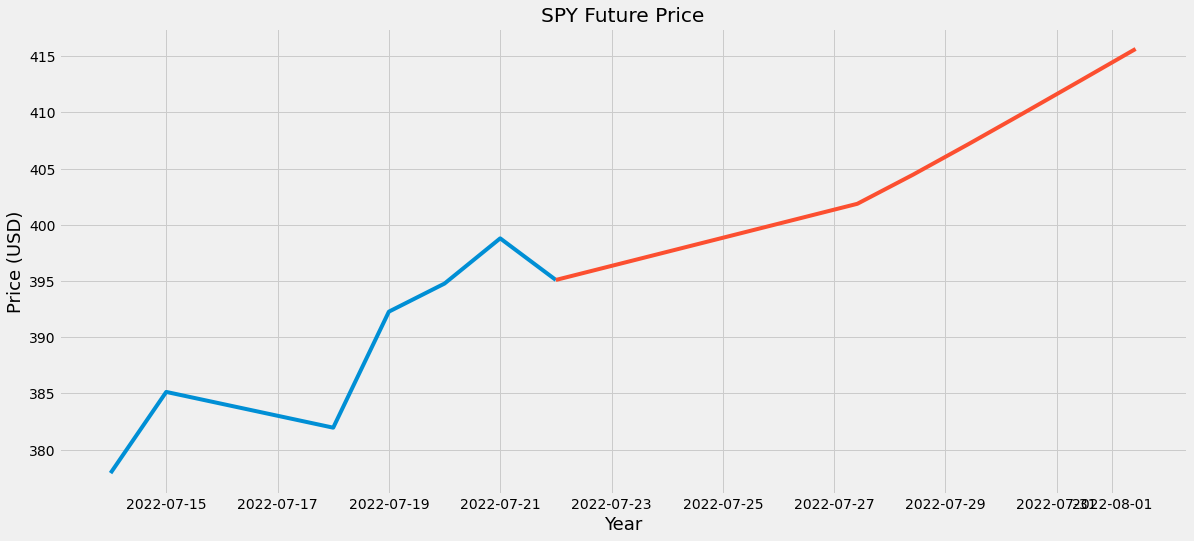

In [28]:
# Predicts and plots future trajectory of stock for the next week (seven days, predicting any longer would be inaccurate due to market fluctuations) based on past data.
for i in range(1, 7):
  last_60_days = new_df[-60:].values
  last_60_days_scaled = scaler.transform(last_60_days)
  new_x_test = []
  new_x_test.append(last_60_days_scaled)
  new_x_test = np.array(new_x_test)
  new_x_test = np.reshape(new_x_test, (new_x_test.shape[0], new_x_test.shape[1], 1))
  pred_price = model.predict(new_x_test, )
  pred_price = scaler.inverse_transform(pred_price)
  new_df = new_df.append(pd.Series({"Close": pred_price[0][0]}, name = dt.datetime.today() + relativedelta(days= i + 1)))

plt.figure(figsize=(18,8))
plt.title("SPY Future Price")
plt.plot(recent_df["Close"][-7:])
plt.plot(new_df["Close"][-7:])
plt.xlabel("Year", fontsize = 18)
plt.ylabel("Price (USD)", fontsize = 18)
plt.show()

for i in range(1, 7):
  recent_last_60_days = recent_new_df[-60:].values
  recent_last_60_days_scaled = scaler.transform(recent_last_60_days)
  recent_new_x_test = []
  recent_new_x_test.append(recent_last_60_days_scaled)
  recent_new_x_test = np.array(recent_new_x_test)
  recent_new_x_test = np.reshape(recent_new_x_test, (recent_new_x_test.shape[0], recent_new_x_test.shape[1], 1))
  recent_pred_price = recent_model.predict(recent_new_x_test, )
  recent_pred_price = scaler.inverse_transform(recent_pred_price)
  recent_new_df = recent_new_df.append(pd.Series({"Close": recent_pred_price[0][0]}, name = dt.datetime.today() + relativedelta(days= i + 1)))

plt.figure(figsize=(18,8))
plt.title("SPY Future Price")
plt.plot(recent_df["Close"][-7:])
plt.plot(recent_new_df["Close"][-7:])
plt.xlabel("Year", fontsize = 18)
plt.ylabel("Price (USD)", fontsize = 18)
plt.show()